<a href="https://colab.research.google.com/github/MathiasSchindlerCPH/BSE-T2-CML2-repo/blob/main/Project-1-kNN/msch_kNN_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Extended Project 1: $k$-Nearest Neighbours**

---



Course: Computation Machine Learning II

Submission Date: Feb 20, 2022

Student: Mathias Schindler

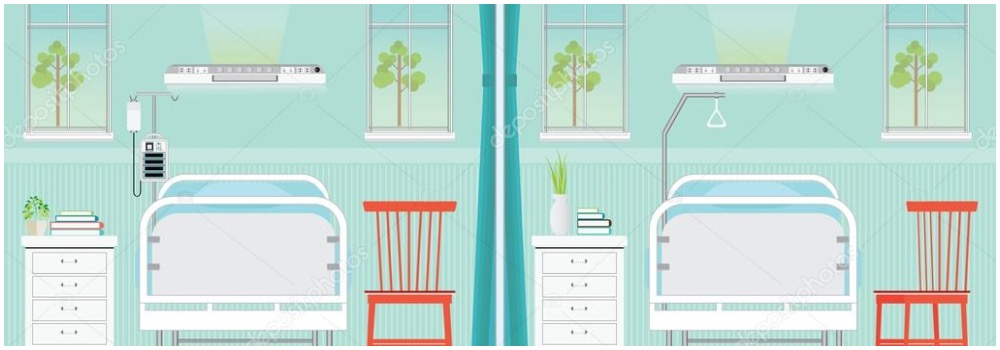

## Instructions

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN_CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 20%
+ Data preparation - 35%
+ Nearest neighbor method(s) have been used - 15%
+ Probability of death for each test patient is computed - 10%
+ Accuracy of predictions for test patients is calculated (kaggle) - 10%
+ Hyperparameter optimization - 5%
+ Class imbalance management - 5%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%



---


Note to self: Resource of how to run `scikit-learn` on `AWS`: [https://towardsdatascience.com/deploying-a-scikit-learn-model-on-aws-using-sklearn-estimators-local-jupyter-notebooks-and-the-d94396589498](https://towardsdatascience.com/deploying-a-scikit-learn-model-on-aws-using-sklearn-estimators-local-jupyter-notebooks-and-the-d94396589498).

---



# **0. Preamble**

In [1]:
# clear everything
%reset -f
print(dir())

['In', 'Out', '__builtin__', '__builtins__', '__name__', '_dh', '_ih', '_oh', '_sh', 'exit', 'get_ipython', 'quit']


In [2]:
# Mount G Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set path
import os
os.chdir('/content/drive/My Drive/--T2-CML2/Project1_kNN')

In [4]:
!ls

data	    mschindler_functions_v5.py	old_scripts  __pycache__
extra_data  msch_kNN_v1.ipynb		preds	     schindlerlib


In [5]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from datetime import datetime, timedelta

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures as plf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import metrics

from imblearn.over_sampling import RandomOverSampler 

In [6]:
#%cd /content/drive/My\ Drive/--T2-CML2/Project1 - kNN, SVM

In [7]:
# import custom functions
from schindlerlib.plots import schindler_plots as my_plots
from schindlerlib.preproz import schindler_preproz as my_preproz
from schindlerlib.postest import schindler_postest as my_postest

print(dir(my_plots)); print(dir(my_preproz)); print(dir(my_postest))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'make_feat_importance_plot', 'make_nan_fig', 'make_roc_plot', 'make_scree_plot', 'missing_plot', 'np', 'p_hat_plot', 'pd', 'plot_confusion_matrix', 'plt', 'sns']
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'construct_age_admit', 'datetime', 'np', 'pd', 'timedelta']
['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'make_multi_point_pred', 'np', 'pd', 'reweight', 'reweight_proba_multi']


# **1. Exploratory Data Analysis**

## 1.1 Load Data

In [8]:
# Load data
df_train = pd.read_csv("data/mimic_train.csv", index_col=3)
df_test = pd.read_csv("data/mimic_test_death.csv", index_col=2)

In [9]:
# Remove identifier variables
id_vars = ['subject_id', 'hadm_id']

df_train = df_train.drop(id_vars, axis = 1)
df_test = df_test.drop(id_vars, axis = 1)

## 1.2 Data Types

In [10]:
# Check data types in datasets
print(df_train.dtypes); print('\n')
print(df_test.dtypes)

HOSPITAL_EXPIRE_FLAG      int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
DOD                      object
ADMITTIME                object
DISCHTIME                object
DEATHTIME                object
Diff    

Variables `GENDER`, `DOB`, `ADMITTIME`, `ADMISSION_TYPE`, `INSURANCE`, `RELIGION`, `MARITAL_STATUS`, `ETHNICITY`, `DIAGNOSIS`, `ICD9_diagnosis`, `FIRST_CAREUNIT` are string.


## 1.3 Missing Data Exploration

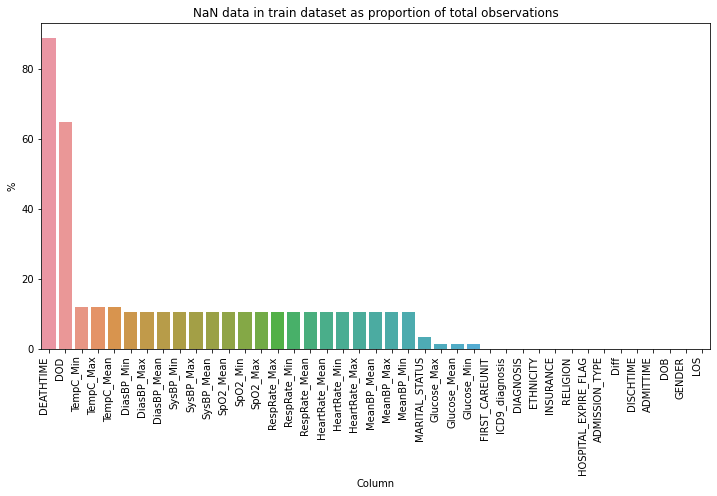

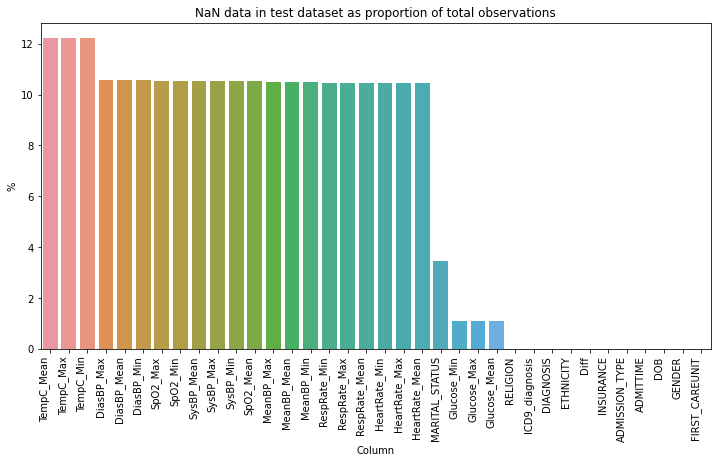

In [11]:
my_plots.missing_plot(df_train, 'train'); my_plots.missing_plot(df_test, 'test')

## 1.4 Feature Distribution

### 1.4.1 Univariate Distributions of Numerical Features

In [12]:
# Save numerical features as list
cols_list = df_train.columns.to_list()
cols_list_str =  ['GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 
                  'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 
                  'FIRST_CAREUNIT']
cols_list_nostr = [var for var in cols_list if var not in cols_list_str]

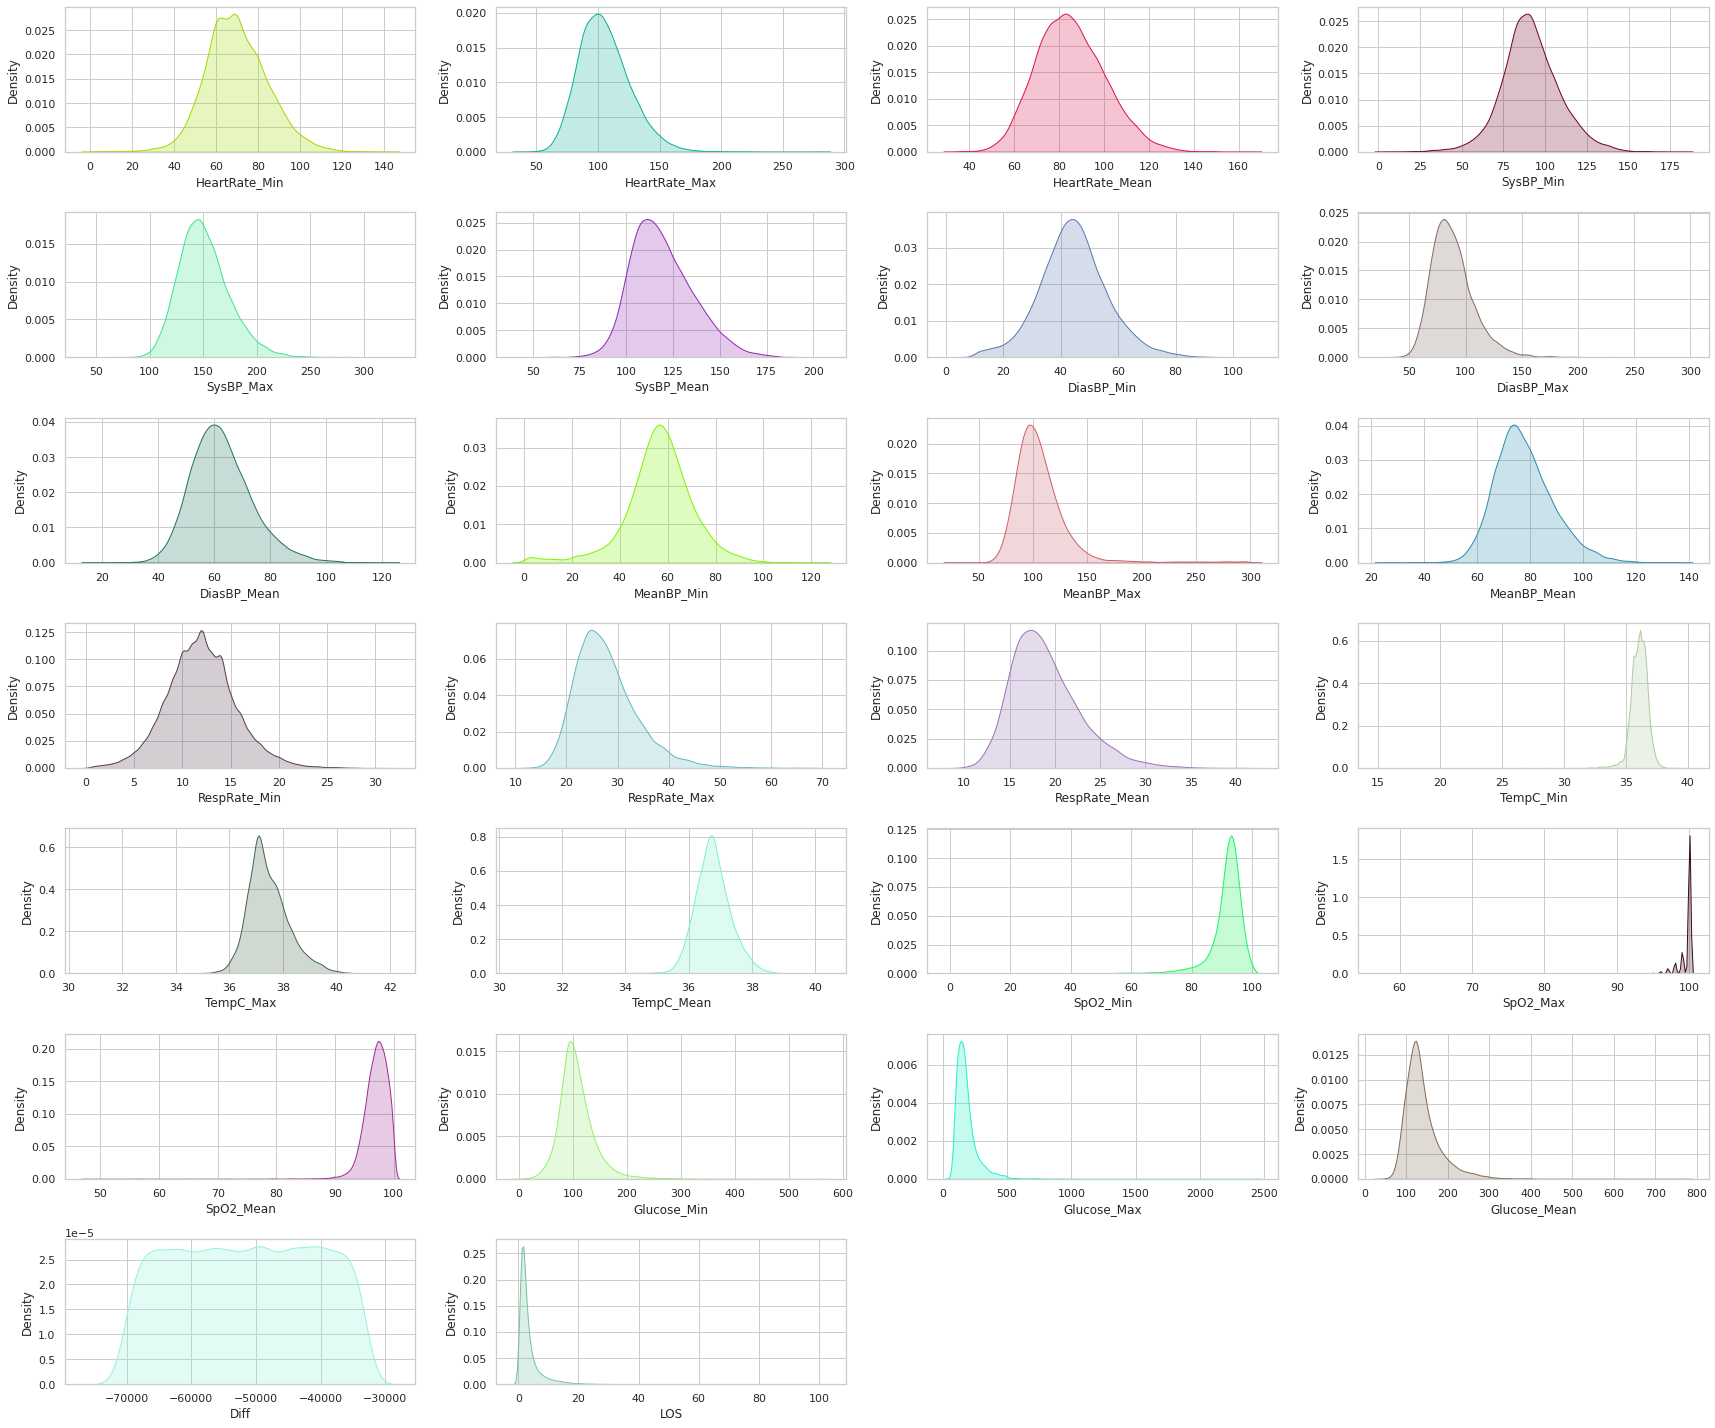

In [13]:
# Univariate kernel density distributions for continuous features
sns.set(style="whitegrid")
plt.figure(figsize=(24, 20)) # Size of the matrix plots

for i, col in enumerate(cols_list_nostr):
  if i == 0:
    pass
  else:
    plt.subplot(7, 4, i) # row, cols and i is the element to plot
    sns.kdeplot(x = col, 
                data = df_train, 
                fill=True, 
                color = np.random.rand(3,) )
plt.tight_layout()

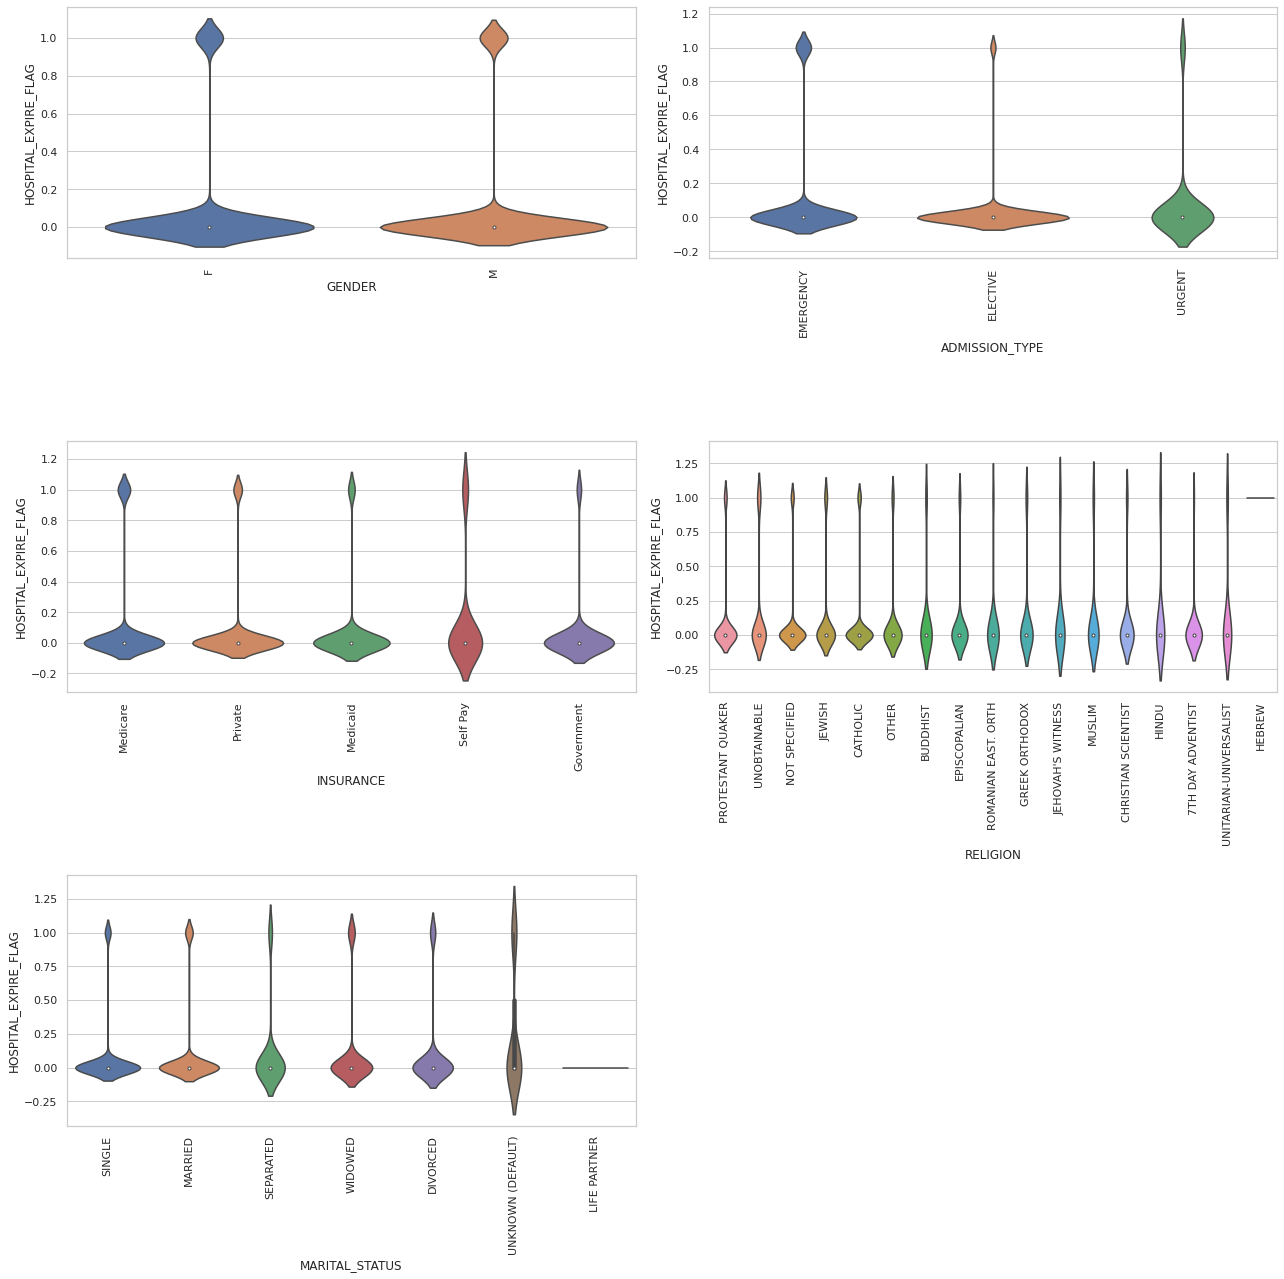

In [55]:
# Univariate violin plot distributions for categorical features
sns.set(style="whitegrid")
plt.figure(figsize=(18, 40)) # Size of the matrix plots
lst = [0, 6, 7, 8, 9]

k = 1
for i in lst:
  plt.subplot(7, 2, k) # row, cols and i is the element to plot
  sns.violinplot(x = cols_list_str[i], y = 'HOSPITAL_EXPIRE_FLAG', data = df_train )
  plt.xticks(rotation=90)
  k += 1

plt.tight_layout()

### 1.4.2 Multivariate Distributions

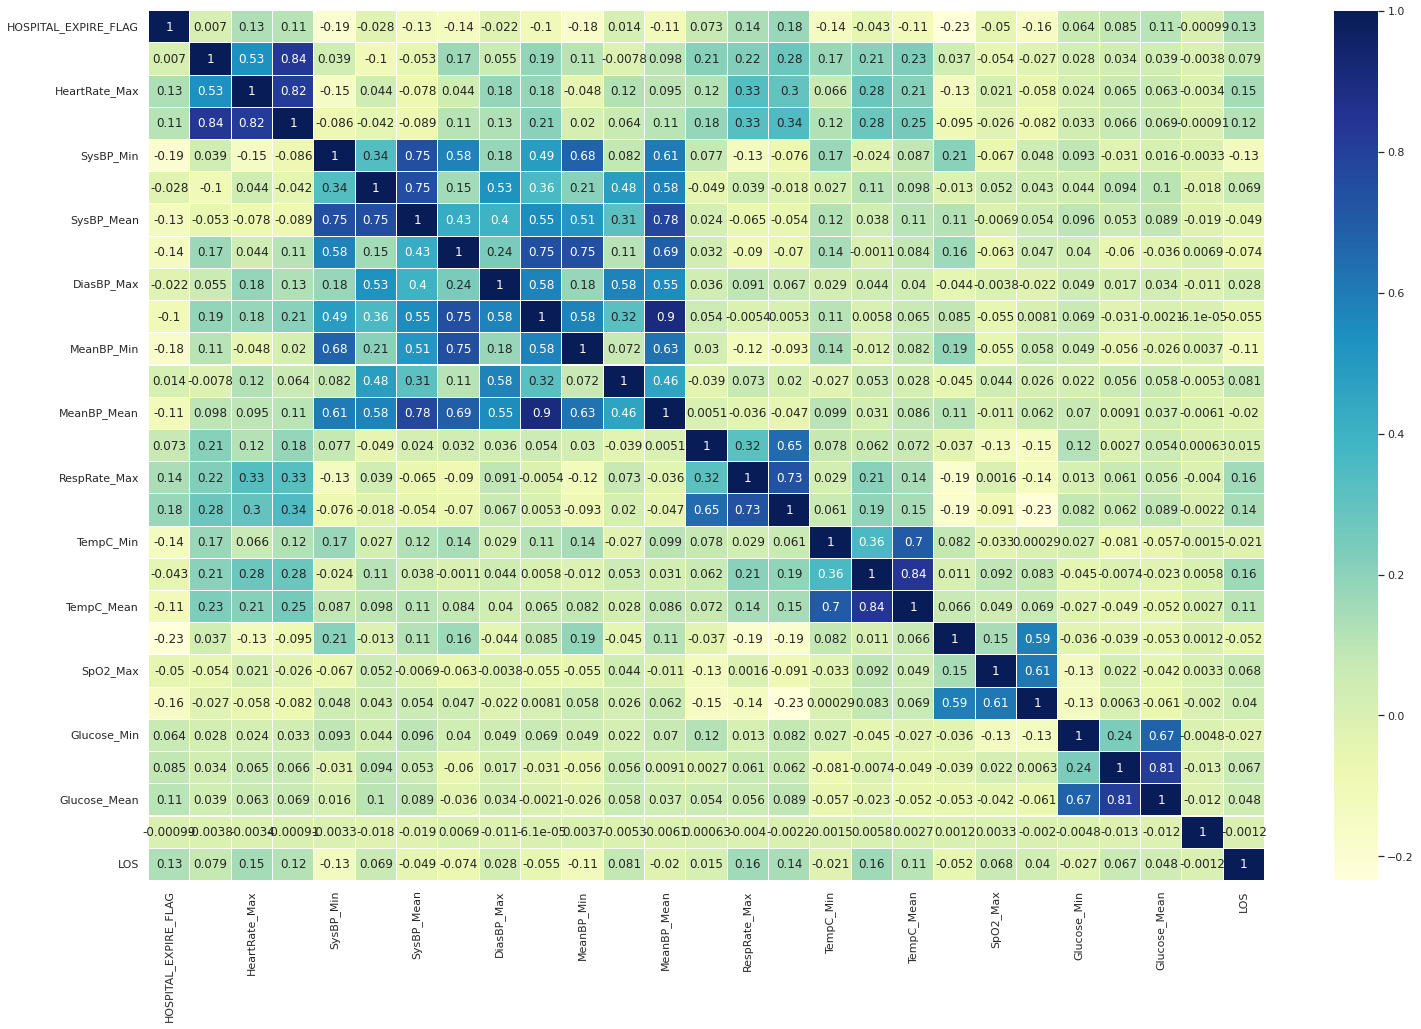

In [18]:
# Heatmap
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_train.corr(), 
            linewidths=0.1, 
            square=False, 
            cmap="YlGnBu", 
            linecolor='white', 
            annot=True)

fig = plt.gcf()
fig.set_size_inches(25, 16)

# **2. Feature Engineering**

## 2.1 Age-at-Admission Variable

### 2.1.1 Format Age Variables using `datetime`

Format admission datetime (see custom functions in external `.py`-file with custom functions).

In [ ]:
df_train_age = my_preproz.construct_age_admit(df_train)
df_test_age = my_preproz.construct_age_admit(df_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### 2.1.2 Inspect Constructed Age Variables

In [ ]:
# Check if missing values were generated
print(df_train_age['age_at_admin'].isnull().any() )
print(df_test_age['age_at_admin'].isnull().any() )

False
False


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


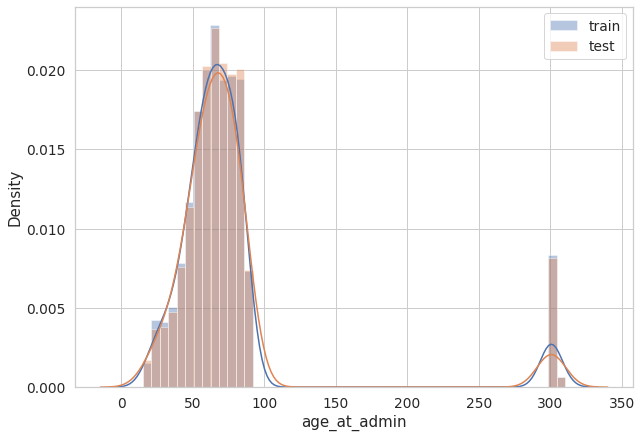

In [ ]:
# Check distribution

# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(df_train_age['age_at_admin'], label='train')
sns.distplot(df_test_age['age_at_admin'], label='test')

# Add legend
plt.legend()

In [ ]:
#Counts of >100-year-olds 
print("No. of individuals in train more than 100 years old: " + str(df_train_age[df_train_age['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts in train for those >100 years:")
print(df_train_age[df_train_age['age_at_admin'] > 100]['age_at_admin'].value_counts() )

print("\n")

print("No. of individuals in test more than 100 years old: " + str(df_test_age[df_test_age['age_at_admin'] > 100]['age_at_admin'].count()))
print("\n Value counts in test for those >100 years:")
print(df_test_age[df_test_age['age_at_admin'] > 100]['age_at_admin'].value_counts() )

No. of individuals in train more than 100 years old: 1107

 Value counts in train for those >100 years:
299.994524    795
300.054757      4
300.021903      3
300.049281      3
301.648186      3
             ... 
300.487337      1
300.514716      1
301.530459      1
301.215606      1
300.788501      1
Name: age_at_admin, Length: 270, dtype: int64


No. of individuals in test more than 100 years old: 270

 Value counts in test for those >100 years:
299.994524    201
300.027379      2
304.859685      2
310.272416      1
304.262834      1
             ... 
300.202601      1
301.059548      1
304.150582      1
302.592745      1
300.539357      1
Name: age_at_admin, Length: 68, dtype: int64


So, those individuals over 100 years old are calculated to be between 299 to 303 years old. Seems quite unrealistic. In order to not delete observations (and for a lack of better alternative) these values are replaced by the median.

### 2.1.3 Clean Constructed Age Variables



---


<font color=red>**NOTE TO SELF:** Revisit this imputation with fancier methods and making sure that no information from train ''spills over'' to test data. 
<br>
Maybe use clustering to impute age from individuals with similar conditions. Prob older people show different characteristics than younger people -> problematic imputing median for all. Co-morbidity info would prob help here.
 </font>


---



In [ ]:
# Train
median_age_train = df_train_age.loc[df_train_age['age_at_admin']<100, 'age_at_admin'].median()
# Set >100 year-olds to missing for var 'age_at_admin'
df_train_age.loc[df_train_age.age_at_admin >= 100, 'age_at_admin'] = np.nan
df_train_age['age_at_admin'].fillna(median_age_train, inplace=True)

# Test
#median_test = df_test_age.loc[df_test_age['age_at_admin']<100, 'age_at_admin'].median()
df_test_age.loc[df_test_age.age_at_admin >= 100, 'age_at_admin'] = np.nan
df_test_age['age_at_admin'].fillna(median_age_train, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


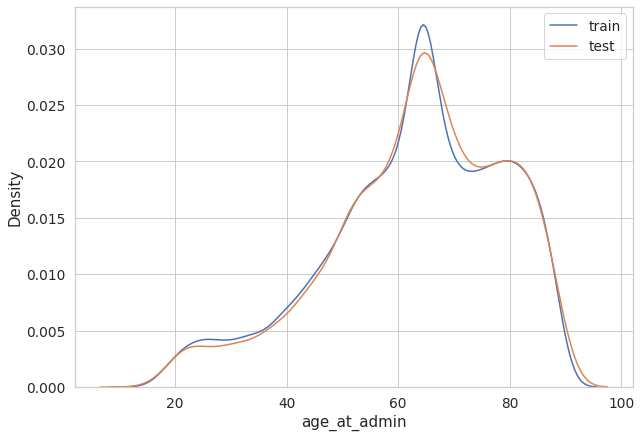

In [ ]:
# Global sns settings
sns.set(rc = {'figure.figsize':(10,7)}, font_scale=1.25)
sns.set_style("whitegrid")

# Make density plot
sns.distplot(df_train_age['age_at_admin'], label='train', hist = False)
sns.distplot(df_test_age['age_at_admin'], label='test', hist = False)

# Add legend
plt.legend()

## 2.2 Co-Morbitidity Index

## 2.3 (Preliminary) Missing Data Imputation



---


<font color=red>**NOTE TO SELF:** Preliminary imputation. Use fancier methods for final submission. 
<br>
Deal with missing string variables `DOD`, `DEATHTIME` and `MARITAL_STATUS`.
 </font>


---



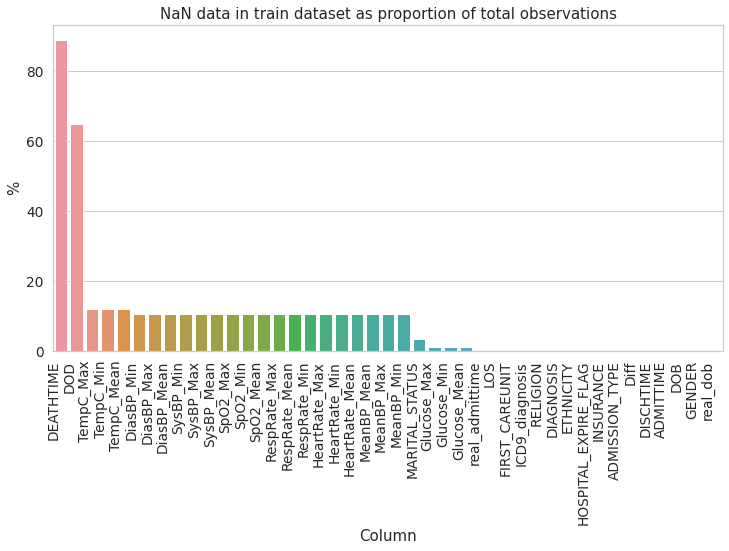

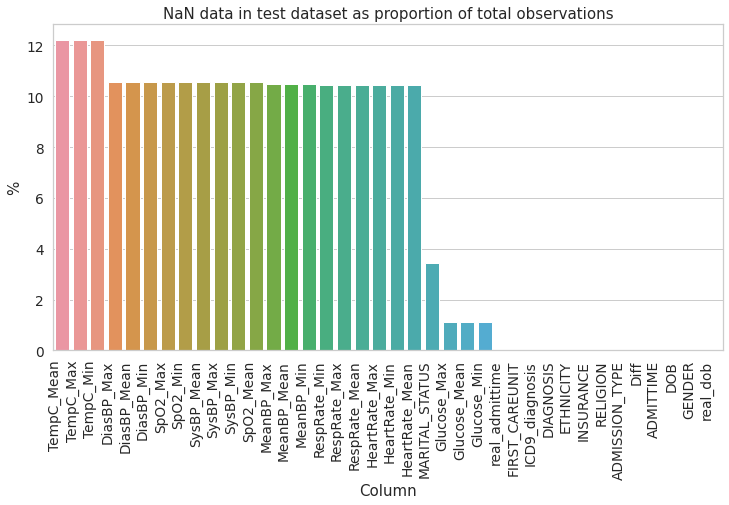

In [ ]:
# Investigate missing data
my_plots.missing_plot(df_train, 'train'); my_plots.missing_plot(df_test, 'test')

In [ ]:
# Save list of features w NA for train and test

na_cols_train = df_train_age.columns[df_train_age.isnull().any()].to_list()
na_cols_test = df_test_age.columns[df_test_age.isnull().any()].to_list()

In [ ]:
# Which NA-cols in train but not test
print(list(set(na_cols_train) - set(na_cols_test)) )
print(list(set(na_cols_test) - set(na_cols_train)) )

['DEATHTIME', 'DOD']
[]


In [ ]:
%%script false

# The following are string and hence cannot be computed means
print(na_cols_train[24:27])

df_train_test['DOD'].mean()
df_train_test['DEATHTIME'].mean()
df_train_test['MARITAL_STATUS'].mean()

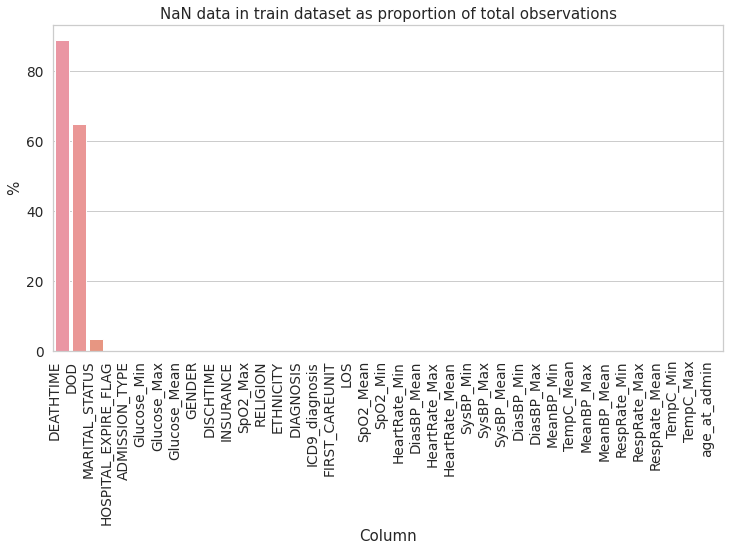

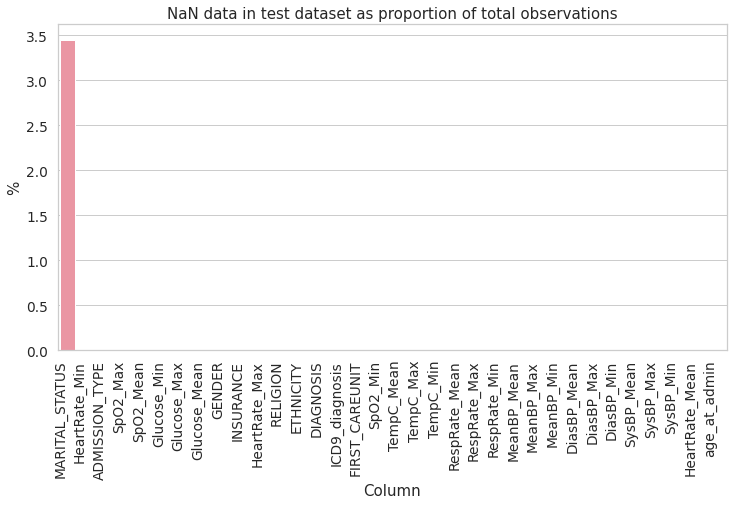

In [ ]:
#Make copies
df_train_fillna = df_train_age.copy()
df_test_fillna = df_test_age.copy()


# Loop over all non-string columns
for k in range(len(na_cols_train[:24])):
  # Calculate mean for given columns
  mean_train = df_train_fillna[na_cols_train[k]].mean()
  
  # Fill NA w. mean for given column (train)
  df_train_fillna[na_cols_train[k]].fillna(mean_train, inplace = True)
  
  # Fill NA w. mean for given column (test w train-mean)
  df_test_fillna[na_cols_train[k]].fillna(mean_train, inplace = True)


# Investigate missing data
my_plots.missing_plot(df_train_fillna, 'train'); my_plots.missing_plot(df_test_fillna, 'test')

### 2.3.1 (Very!) Preliminary Imputation of String NA-Cols

In [ ]:
# Drop 'DEATHTIME' and 'DOD' from train data
df_train_fillna = df_train_fillna.drop(['DEATHTIME', 'DOD'], axis = 1)

In [ ]:
# Fill 'MARITAL_STATUS' w. most frequent observation
most_freq_train = df_train_fillna['MARITAL_STATUS'].value_counts().index[0]

df_train_fillna['MARITAL_STATUS'] = df_train_fillna['MARITAL_STATUS'].fillna(most_freq_train)
df_test_fillna['MARITAL_STATUS'] = df_test_fillna['MARITAL_STATUS'].fillna(most_freq_train)

In [ ]:
# Investigate missing data
print(df_train_fillna.isna().any() )
print(df_test_fillna.isna().any() )

HOSPITAL_EXPIRE_FLAG    False
HeartRate_Min           False
HeartRate_Max           False
HeartRate_Mean          False
SysBP_Min               False
SysBP_Max               False
SysBP_Mean              False
DiasBP_Min              False
DiasBP_Max              False
DiasBP_Mean             False
MeanBP_Min              False
MeanBP_Max              False
MeanBP_Mean             False
RespRate_Min            False
RespRate_Max            False
RespRate_Mean           False
TempC_Min               False
TempC_Max               False
TempC_Mean              False
SpO2_Min                False
SpO2_Max                False
SpO2_Mean               False
Glucose_Min             False
Glucose_Max             False
Glucose_Mean            False
GENDER                  False
DISCHTIME               False
ADMISSION_TYPE          False
INSURANCE               False
RELIGION                False
MARITAL_STATUS          False
ETHNICITY               False
DIAGNOSIS               False
ICD9_diagn

# **3. Preprocessing Data**

Compare features in both data sets

In [ ]:
print("Features in train data but not in test:")
print(df_train_fillna.columns.difference(df_test_fillna.columns) )

print("\n Features in test data but not in train:")
print(df_test_fillna.columns.difference(df_train_fillna.columns) )

Features in train data but not in test:
Index(['DISCHTIME', 'HOSPITAL_EXPIRE_FLAG', 'LOS'], dtype='object')

 Features in test data but not in train:
Index([], dtype='object')


In [ ]:
# Remove features in train that are not in test (except target 'HOSPITAL_EXPIRE_FLAG')
df_train_fillna = df_train_fillna.drop(['DISCHTIME', 'LOS'], axis = 1)

In [ ]:
print(df_train_fillna.columns.difference(df_test_fillna.columns) )
print(df_test_fillna.columns.difference(df_train_fillna.columns) )

Index(['HOSPITAL_EXPIRE_FLAG'], dtype='object')
Index([], dtype='object')


## 3.0 Split Categorical and Numerical Data

In [ ]:
# Numerical Data
cat_feats = ["GENDER", "ADMISSION_TYPE", "INSURANCE", "RELIGION", "MARITAL_STATUS", 
             "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis", "FIRST_CAREUNIT"]

df_train_num = df_train_fillna.drop(cat_feats, axis = 1)
df_test_num = df_test_fillna.drop(cat_feats, axis = 1)

In [ ]:
# Categorical Data
df_train_cat = df_train_fillna[cat_feats]
df_test_cat = df_test_fillna[cat_feats]

In [ ]:
# Split target
y_train = df_train_fillna['HOSPITAL_EXPIRE_FLAG']
df_train_num = df_train_num.drop(['HOSPITAL_EXPIRE_FLAG'], axis = 1)

Compare again

In [ ]:
# Compare numerical features
print(df_train_num.columns.difference(df_test_num.columns) )
print(df_test_num.columns.difference(df_train_num.columns) )

Index([], dtype='object')
Index([], dtype='object')


In [ ]:
# Compare categorical features
print(df_train_cat.columns.difference(df_test_cat.columns) )
print(df_test_cat.columns.difference(df_train_cat.columns) )

Index([], dtype='object')
Index([], dtype='object')


## 3.1 Numerical Features 

### 3.1.2 Polynomial Transformations

In [ ]:
# Set degree  and save column names
degree = 2 


# Instantiate
poly = plf(degree, include_bias = False)

# Fit 
poly.fit(df_train_num)

# Save polynomial column names
poly_col_names = poly.get_feature_names(df_train_num.columns)

# Transform data
df_train_poly, df_test_poly = poly.transform(df_train_num), poly.transform(df_test_num)

# Dataframes
df_train_poly = pd.DataFrame(df_train_poly, 
                             columns = poly_col_names, 
                             index = df_train_num.index)
df_test_poly = pd.DataFrame(df_test_poly, 
                            columns = poly_col_names, 
                            index = df_test_num.index)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### 3.1.2 Standardization

Data will be standardized with mean zero and unit variance. This such that distance measures are in comparable units.

In [ ]:
# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to train 
scaler.fit(df_train_poly)

# Transform train and test
df_train_scl = scaler.transform(df_train_poly)
df_test_scl = scaler.transform(df_test_poly)

# Format data
df_train_scl = pd.DataFrame(df_train_scl, 
                            columns = df_train_poly.columns, 
                            index = df_train_poly.index)
df_test_scl = pd.DataFrame(df_test_scl, 
                           columns = df_test_poly.columns, 
                           index = df_test_poly.index)

## 3.2 Categorical Features

### 3.2.1 One-Hot Encoding

Inspecting for which features it would be feasible to construct dummy variables.<br>
Features `GENDER`, `ADMISSION_TYPE`, `INSURANCE`, `MARITAL_STATUS` and `FIRST_CAREUNIT` are chosen for one-hot encoding. These seem relevant for the later task of predicting mortality, while having a not-too-large number of categories (so dimensionality does not explode).



---


 <font color=red>**NOTE TO SELF:** Also try one-hotting everything and then dimensionality-reducing with PCA and/or SVD</font>


---



In [ ]:
for c in cat_feats:
  print(str(c) + ":"); print(df_train_cat[c].value_counts() ); print("\n")

GENDER:
M    11759
F     9126
Name: GENDER, dtype: int64


ADMISSION_TYPE:
EMERGENCY    17817
ELECTIVE      2848
URGENT         220
Name: ADMISSION_TYPE, dtype: int64


INSURANCE:
Medicare      11718
Private        6245
Medicaid       2117
Government      611
Self Pay        194
Name: INSURANCE, dtype: int64


RELIGION:
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: RELIGION, dtype: int64


MARITAL_STATUS:
MARRIED              10386
SINGLE                5910
WIDOWED               2819
DIVORCED              1

In [ ]:
# One-Hot Encoding
one_hot_feats = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS', 'FIRST_CAREUNIT']
prfx_dict = {'GENDER': 'gender', 'ADMISSION_TYPE': 'admin_type', 'INSURANCE': 'ins', 'MARITAL_STATUS': 'mar_stat','FIRST_CAREUNIT': 'firstcare'}

df_train_dumm = pd.get_dummies(df_train_cat, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)
df_test_dumm = pd.get_dummies(df_test_cat, prefix=prfx_dict, columns=one_hot_feats, drop_first = True)

In [ ]:
# Drop non-one-hot encoded features
drop_cat_feats = [ "RELIGION", "ETHNICITY", "DIAGNOSIS", "ICD9_diagnosis"]

df_train_dumm = df_train_dumm.drop(drop_cat_feats, axis = 1)
df_test_dumm = df_test_dumm.drop(drop_cat_feats, axis = 1)

## 3.3 Concatenate Numerical and Categorical Features

Print and check final datasets to be used for estimation.

In [ ]:
X_train = pd.concat([df_train_scl, df_train_dumm], axis = 1)
X_test = pd.concat([df_test_scl, df_test_dumm], axis = 1)

In [ ]:
print("Shape: " + str(X_train.shape))
X_train

Shape: (20885, 367)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,HeartRate_Min^2,HeartRate_Min HeartRate_Max,HeartRate_Min HeartRate_Mean,HeartRate_Min SysBP_Min,HeartRate_Min SysBP_Max,HeartRate_Min SysBP_Mean,HeartRate_Min DiasBP_Min,HeartRate_Min DiasBP_Max,HeartRate_Min DiasBP_Mean,HeartRate_Min MeanBP_Min,HeartRate_Min MeanBP_Max,HeartRate_Min MeanBP_Mean,HeartRate_Min RespRate_Min,HeartRate_Min RespRate_Max,HeartRate_Min RespRate_Mean,...,SpO2_Min Glucose_Mean,SpO2_Min age_at_admin,SpO2_Max^2,SpO2_Max SpO2_Mean,SpO2_Max Glucose_Min,SpO2_Max Glucose_Max,SpO2_Max Glucose_Mean,SpO2_Max age_at_admin,SpO2_Mean^2,SpO2_Mean Glucose_Min,SpO2_Mean Glucose_Max,SpO2_Mean Glucose_Mean,SpO2_Mean age_at_admin,Glucose_Min^2,Glucose_Min Glucose_Max,Glucose_Min Glucose_Mean,Glucose_Min age_at_admin,Glucose_Max^2,Glucose_Max Glucose_Mean,Glucose_Max age_at_admin,Glucose_Mean^2,Glucose_Mean age_at_admin,age_at_admin^2,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,mar_stat_LIFE PARTNER,mar_stat_MARRIED,mar_stat_SEPARATED,mar_stat_SINGLE,mar_stat_UNKNOWN (DEFAULT),mar_stat_WIDOWED,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU
icustay_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
228357,1.371353e+00,2.008463e+00,2.474416e+00,-1.032036e+00,-1.052701e+00,-7.951633e-01,-2.066980e-01,8.988579e-02,-1.284776e-01,1.993805e-01,-5.008976e-01,-2.915794e-01,9.115543e-01,3.736866e-01,9.230392e-01,-1.368516e+00,-6.453202e-01,-1.185847e+00,-1.439672e-01,-5.067807e-01,-5.109988e-01,0.120638,0.519763,0.490860,0.420258,1.408637,2.091316,2.105749,0.128976,0.329015,0.608682,0.561135,0.990799,0.835438,0.993131,0.378407,0.870231,1.491311,1.096254,1.489180,...,0.448410,0.370724,-0.540057,-0.584248,0.104656,0.505178,0.472170,0.395981,-0.547832,0.087212,0.489876,0.452910,0.372183,-0.028479,0.329801,0.159013,0.342869,0.134173,0.275412,0.695124,0.258033,0.656627,0.336869,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
221004,-4.766311e-01,2.404587e-01,-4.182947e-01,-1.273002e-01,-1.318917e+00,-7.858952e-01,4.148556e-01,-7.874681e-01,2.133819e-01,1.257251e-01,-8.840143e-01,-2.671844e-01,3.197882e-01,-1.141409e+00,-8.036251e-01,4.106957e-01,-1.089446e+00,-4.936007e-01,9.992039e-01,4.048877e-01,9.934597e-01,-0.108167,-0.859167,-0.802892,-1.297563,-0.535030,-0.214045,-0.507214,-0.429614,-1.131338,-0.800761,-0.026735,-0.815402,-0.242103,-0.221518,-0.906723,-0.512005,-0.066201,-0.968458,-0.745413,...,-0.613493,-1.060678,0.423147,0.912506,-0.094283,-0.853691,-0.793891,-1.284787,1.047656,-0.039323,-0.832834,-0.754061,-1.237507,-0.188922,-0.595879,-0.426198,-0.831989,-0.370374,-0.593688,-1.101891,-0.601739,-1.202694,-1.292842,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
296315,8.027428e-01,-3.657143e-01,4.491223e-01,-1.876159e-01,-5.646396e-01,-4.026771e-01,5.968212e-02,-1.171310e+00,-5.465059e-01,5.676576e-01,-7.307676e-01,-4.489295e-01,3.197882e-01,-1.141409e+00,-8.472305e-01,5.724422e-01,-7.193412e-01,-1.502029e-01,1.284997e+00,4.048877e-01,1.419993e+00,0.721252,1.779258,1.764030,0.332998,0.739764,0.174876,0.595331,0.438225,0.279410,0.429776,0.477154,-0.402695,0.171424,0.942172,-0.139157,0.344966,0.640113,-0.389051,-0.113864,...,2.218321,0.743067,0.423147,1.241868,0.743051,1.794307,1.789990,0.352024,1.509891,0.855096,1.897998,1.934605,0.473439,0.449756,1.579385,1.038905,0.785540,0.931311,1.538473,1.863702,1.471835,1.647648,0.234736,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
245557,4.473612e-01,1.149718e+00,9.436496e-01,-4.288789e-01,-6.977473e-01,-7.707219e-01,-1.272218e+00,3.505117e-02,-1.982988e+00,-6.108291e-01,-5.008976e-01,-1.409916e+00,2.390518e-02,1.215407e+00,2.137552e+00,4.106957e-01,2.759647e+00,1.910184e+00,-1.858724e+00,4.048877e-01,-8.071218e-01,0.034836,-0.468289,-0.

In [ ]:
print("Shape: " + str(X_test.shape))
X_test

Shape: (5221, 367)


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,age_at_admin,HeartRate_Min^2,HeartRate_Min HeartRate_Max,HeartRate_Min HeartRate_Mean,HeartRate_Min SysBP_Min,HeartRate_Min SysBP_Max,HeartRate_Min SysBP_Mean,HeartRate_Min DiasBP_Min,HeartRate_Min DiasBP_Max,HeartRate_Min DiasBP_Mean,HeartRate_Min MeanBP_Min,HeartRate_Min MeanBP_Max,HeartRate_Min MeanBP_Mean,HeartRate_Min RespRate_Min,HeartRate_Min RespRate_Max,HeartRate_Min RespRate_Mean,...,SpO2_Min Glucose_Mean,SpO2_Min age_at_admin,SpO2_Max^2,SpO2_Max SpO2_Mean,SpO2_Max Glucose_Min,SpO2_Max Glucose_Max,SpO2_Max Glucose_Mean,SpO2_Max age_at_admin,SpO2_Mean^2,SpO2_Mean Glucose_Min,SpO2_Mean Glucose_Max,SpO2_Mean Glucose_Mean,SpO2_Mean age_at_admin,Glucose_Min^2,Glucose_Min Glucose_Max,Glucose_Min Glucose_Mean,Glucose_Min age_at_admin,Glucose_Max^2,Glucose_Max Glucose_Mean,Glucose_Max age_at_admin,Glucose_Mean^2,Glucose_Mean age_at_admin,age_at_admin^2,gender_M,admin_type_EMERGENCY,admin_type_URGENT,ins_Medicaid,ins_Medicare,ins_Private,ins_Self Pay,mar_stat_LIFE PARTNER,mar_stat_MARRIED,mar_stat_SEPARATED,mar_stat_SINGLE,mar_stat_UNKNOWN (DEFAULT),mar_stat_WIDOWED,firstcare_CSRU,firstcare_MICU,firstcare_SICU,firstcare_TSICU
icustay_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
208169,-8.320127e-01,-7.698297e-01,4.460470e-03,-8.510890e-01,1.008993e-01,-1.307780e+00,-3.842848e-01,-6.229642e-01,-1.007827e+00,-2.425520e-01,-1.944042e-01,-8.948388e-01,-1.751393e+00,-6.363774e-01,-1.837236e+00,-1.093547e+00,1.027555e+00,1.153991e+00,5.705147e-01,4.048877e-01,1.053583e+00,-0.508576,0.519763,-0.093424,1.169323,-0.832580,-0.873822,-0.525364,-1.080635,-0.634898,-1.317037,-0.719357,-0.921142,-1.078995,-0.662656,-0.645851,-1.056278,-1.487884,-0.862694,-1.428303,...,0.041946,1.366251,0.423147,0.958932,-0.498513,0.530242,-0.079735,1.191555,1.112546,-0.449689,0.578756,-0.019955,1.295288,-0.440832,0.015885,-0.314781,0.182111,0.134173,0.077614,1.119806,-0.176897,0.602149,1.298804,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
251754,1.513506e+00,2.008463e+00,2.061274e+00,-1.092352e+00,-3.427933e-01,-1.135582e+00,-2.066980e-01,-1.294527e-01,2.945977e-01,-4.635182e-01,6.471826e+00,7.028269e-01,2.390969e+00,2.057127e+00,1.952540e+00,6.329384e-03,2.685626e+00,1.910184e+00,2.847219e-01,4.048877e-01,3.625453e-01,1.293265,9.053929,5.657750,-0.903354,1.585692,2.203208,1.969056,0.161498,1.007602,0.467800,0.636989,0.891533,1.248074,0.459963,7.380983,1.661779,2.955252,2.583092,2.371633,...,5.772955,-0.808678,0.423147,0.425325,1.320523,9.095372,5.709436,-0.889067,0.371946,1.346136,9.132177,5.766329,-0.877388,0.982067,8.326715,3.528101,0.215464,11.818231,12.167067,5.802625,7.447581,2.762438,-0.989809,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
242171,2.579651e+00,1.351776e+00,2.247179e+00,1.139627e-01,-6.090088e-01,-1.850880e-01,5.924424e-01,-6.777989e-01,4.026234e-01,2.730359e-01,-7.690793e-01,-2.504734e-02,1.207437e+00,-1.313454e-01,8.471534e-01,1.623795e+00,2.315521e+00,2.876226e+00,1.418255e-01,4.048877e-01,-4.431295e-01,-0.193969,-0.359712,-0.355055,-1.290719,3.039015,2.510718,2.877041,1.995885,1.606426,2.054498,2.067384,1.015615,2.117903,1.836616,0.736270,1.995255,2.580966,1.390556,2.290900,...,-0.316956,-1.222989,0.423147,-0.196804,-0.180904,-0.352424,-0.343095,-1.277917,-0.477027,-0.222619,-0.375655,-0.383975,-1.316871,-0.245996,-0.329671,-0.289464,-0.871963,-0.232077,-0.339318,-0.801247,-0.346749,-0.970650,-1.287942,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
263035,1.630559e-01,-1.211341e-02,-1.071597e-01,-1.152668e+00,7.664381e-01,4.961764e-01,-4.730781e-01,5.833973e-01,3.293636e-02,-7.581399e-01,1.120891e-01,8.468245e-02,-5.678609e-01,-2.996894e-01,-1.368881e+00,-1.554171e-01,4.649952e-01,3.115083e-01,-2.868636e-01,4.048877e-01,-7.223690e-01,0.664051,-0.055696,0.

## 3.4 Principal Component Analysis

# **4.0 Estimation using $k$-NN**

## 4.1 Dealing with Class Imbalance

In [ ]:
y_train.value_counts()

0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

In [ ]:
# RandomOverSampler
ros = RandomOverSampler(sampling_strategy = 'auto')

X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
y_ros.value_counts()

0    18540
1    18540
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64

## 4.2 Run Model



---


<font color=red>**NOTE TO SELF:** Inspired from [https://www.datasklr.com/select-classification-methods/k-nearest-neighbors](https://www.datasklr.com/select-classification-methods/k-nearest-neighbors).
 </font>


---



In [ ]:
# Set pipeline
KNN = KNeighborsClassifier()

#n_neighbors = [2, 3, 5, 10]
#n_neighbors = [2, 15, 20, 25]
#n_neighbors = [25, 30, 35, 40, 45, 60, 70, 90]
n_neighbors = [90, 130, 150, 170, 200, 250, 300, 350, 400]
    
leaf_size = [20,40,1]
p =  [1,2]
weights = ['uniform', 'distance']
metric = ['minkowski', 'chebyshev']
algorithm = ["auto",  "ball_tree", "kd_tree", "brute"]


# Pipeline
pipe = Pipeline(steps=[("KNN", KNN)])

parameters = dict(KNN__n_neighbors = n_neighbors,
                  KNN__algorithm = algorithm,
                  KNN__leaf_size = leaf_size,
                  KNN__p = p,
                  KNN__weights = weights,
                  KNN__metric = metric)

In [ ]:
%%time 
# Print of NN candidates
print("NN Candidates: "+ str(n_neighbors))

# Instantiate grid search and pipe
# RandomizedSearchCV() is used to save computing time compared to GridSearchCV()
clf = RandomizedSearchCV(pipe, parameters,
                         scoring = 'roc_auc', 
                         cv = 5, 
                         n_jobs = -1)
'''
clf = GridSearchCV(pipe, parameters, 
                   scoring = 'roc_auc', 
                   cv = 5, 
                   n_jobs = -1)
'''

# Run grid search
clf.fit(X_ros, y_ros)

# Save best parameters
best_nn = clf.best_estimator_.get_params()['KNN__n_neighbors']
best_alg = clf.best_estimator_.get_params()['KNN__algorithm']
best_leaf_size = clf.best_estimator_.get_params()['KNN__leaf_size']
best_p = clf.best_estimator_.get_params()['KNN__p']
best_weights = clf.best_estimator_.get_params()['KNN__weights']
best_metric = clf.best_estimator_.get_params()['KNN__metric']

#print('Best #Nearest-Neighbors: ', best_nn); print('Best Algorithm:', best_alg); print('Best Leaf Size:', best_leaf_size)
#print('Best p:', best_p); print('Best Weights:', best_weights); print('Best Metric:', best_metric)

print(clf.best_params_ )

NN Candidates: [90, 130, 150, 170, 200, 250, 300, 350, 400]


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'KNN__weights': 'distance', 'KNN__p': 1, 'KNN__n_neighbors': 150, 'KNN__metric': 'chebyshev', 'KNN__leaf_size': 20, 'KNN__algorithm': 'brute'}
CPU times: user 50.7 s, sys: 9.98 s, total: 1min
Wall time: 1h 45min 15s


Now, using the best parameters from the grid search the model is fitted on the training data.

Best NN: 150
Best Algorithm: brute
Best Leaf Size: 20
Best p: 1
Best Weights: distance
Best Metric: chebyshev
CPU times: user 15min 30s, sys: 815 ms, total: 15min 31s
Wall time: 15min 27s


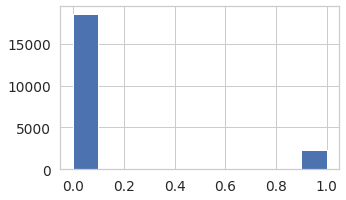

In [ ]:
%%time 
# Print hyperparameters from grid search
print('Best NN: ' + str(best_nn)); print('Best Algorithm: ' + str(best_alg)); print('Best Leaf Size: ' + str(best_leaf_size))
print('Best p: ' + str(best_p)); print('Best Weights: ' + str(best_weights)); print('Best Metric: ' + str(best_metric))

# Instantiate
knn = KNeighborsClassifier(n_neighbors = best_nn, 
                           algorithm = best_alg,
                           leaf_size = best_leaf_size,
                           p = best_p,
                           weights = best_weights,
                           metric = best_metric)

# Fit (using oversampled data)
knn.fit(X_ros, y_ros)

# Predict (using original, unbalanced data)
y_hat = knn.predict(X_train)
p_hat = knn.predict_proba(X_train)[:,1]

# Plot p_hat distribution
my_plots.p_hat_plot(p_hat)

## 4.3 Model Evaluation

### 4.3.1 Cross-Validation

### 4.3.2 AUC

In [ ]:
# Set correct weights for correction function
y_train = np.array(y_train)
y_ros = np.array(y_ros)

# Ratio of 1s in original target
q1 = y_train.sum()/len(y_train)

# Ratio of 1s in resampled target
r1 = y_ros.sum()/len(y_ros)


# Apply correction function
p_hat = pd.Series(p_hat)
p_hat_corr = p_hat.apply(my_postest.reweight, args=(q1,r1))

print('Shape: ' + str(p_hat_corr.shape)) #; print(p_hat_corr)

Shape: (20885,)


1.0


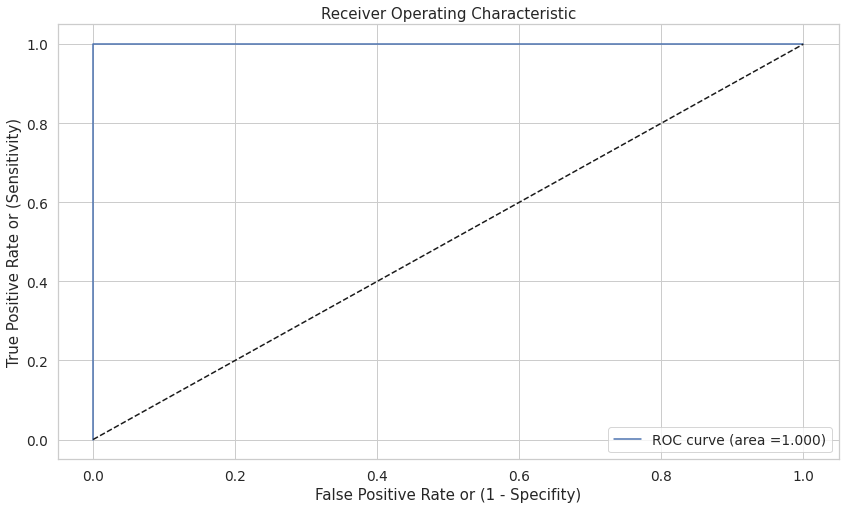

In [ ]:
# Calculate AUC
fpr, tpr, thrs = metrics.roc_curve(y_train, p_hat_corr)
roc_auc_score = metrics.auc(fpr, tpr)
print(roc_auc_score)

# AUC-Plot
my_plots.make_roc_plot(fpr, tpr, roc_auc_score)

# _Export Predictions for Kaggle Competition

In [ ]:
# Predict obervations using test data
y_hat_test = knn.predict(X_test)

In [ ]:
# Format df for submission
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_hat_test})

# Save strings for filename
bestNNstr = str(best_nn)
bestALGstr = str(best_alg)
bestLEAFstr =  str(best_leaf_size)
bestPstr = str(best_p)
bestWEIGHTstr =  str(best_weights)
bestMETRICstr = str(best_metric)
date_filename = str(datetime.now().strftime('%Y_%m_%d_%H_%M'))

# Save .csv file
test_predictions_submit.to_csv("preds/preds-" 
                               + date_filename + '-'
                               + 'NN_' + bestNNstr + '-'
                               + 'ALG_' + bestALGstr + '-'
                               + 'LEAF_' + bestLEAFstr + '-'
                               + 'P_' + bestPstr + '-'
                               + 'WEIGHT_' + bestWEIGHTstr + '-'
                               + 'METRIC_' + bestMETRICstr 
                               + ".csv", index = False)